Loaded European goals data
Loaded Elo ratings data
Replaced team names in European Championship results and filtered years >= 1984
Added competition start dates
Replaced team names in Elo dataset
Merged Elo ratings for home teams
Merged Elo ratings for away teams
Dropped redundant columns
Found 0 rows with missing Elo data
Calculated Elo-based probabilities
Extracted actual match outcomes
Compared actual outcomes with probabilities
Flagged surprising results
Identified 849 rows after processing
Prepared 849 rows with valid Elo data for distribution analysis


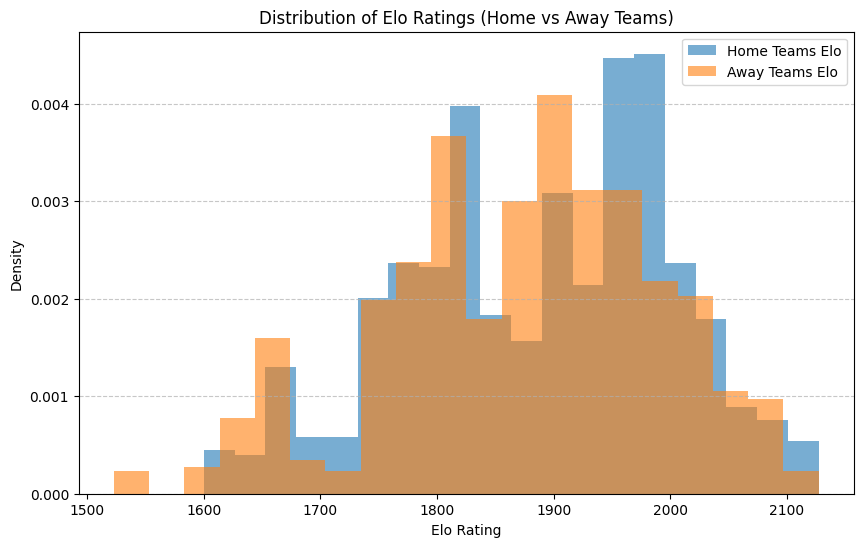

Displayed Elo rating distributions


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from getpass import getuser


# Get the current user's name
user = getuser()


# Path to the dataset
data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\eu_goals_men.xlsx'

# Read the dataset with a different encoding
eu_goals = pd.read_excel(data_path, sheet_name=None)  # Load all sheets as a dictionary
print("Loaded European goals data")

data_path = rf'C:\Users\{user}\Documents\GitHub\tiebreak_wc\data\in\elo_eu.xlsx'
elo_eu = pd.read_excel(data_path)
print("Loaded Elo ratings data")

# Dictionary of replacements for team names
replacements = {
    "Republic of Ireland": "Ireland",
    "CIS": "Commonwealth of Independent States",
    "FR Yugoslavia": "Yugoslavia"
}

eu_results = eu_goals["Sheet1"]
eu_results["home_team"] = eu_results["home_team"].replace(replacements)
eu_results["away_team"] = eu_results["away_team"].replace(replacements)
eu_results = eu_results[eu_results["year"] >= 1984]  # Filter for years from 1984
print("Replaced team names in European Championship results and filtered years >= 1984")

print("Added competition start dates")

# Prepare the Elo dataset for integration: rename columns for clarity
elo_eu = elo_eu.rename(columns={"team": "team_name", "elo_rating": "elo"})
elo_eu["team_name"] = elo_eu["team_name"].replace(replacements)
print("Replaced team names in Elo dataset")

# Merge Elo ratings with results for home and away teams
eu_results = eu_results.merge(
    elo_eu[["year", "team_name", "elo"]],
    left_on=["year", "home_team"],
    right_on=["year", "team_name"],
    how="left"
).rename(columns={"elo": "elo_home"})
print("Merged Elo ratings for home teams")

eu_results = eu_results.merge(
    elo_eu[["year", "team_name", "elo"]],
    left_on=["year", "away_team"],
    right_on=["year", "team_name"],
    how="left"
).rename(columns={"elo": "elo_away"})
print("Merged Elo ratings for away teams")

# Drop redundant columns and inspect the resulting dataset
eu_results = eu_results.drop(columns=["team_name_x", "team_name_y"])
print("Dropped redundant columns")

# Check for missing data in Elo columns
missing_elo_data = eu_results[eu_results["elo_home"].isna() | eu_results["elo_away"].isna()]
print(f"Found {len(missing_elo_data)} rows with missing Elo data")

# Calculate Elo-based probabilities of victory for home and away teams
def calculate_elo_probabilities(elo_home, elo_away):
    prob_home_win = 1 / (1 + 10 ** ((elo_away - elo_home) / 400))
    prob_away_win = 1 / (1 + 10 ** ((elo_home - elo_away) / 400))
    prob_draw = 1 - (prob_home_win + prob_away_win)  # Assumes draws are less likely
    return prob_home_win, prob_draw, prob_away_win

# Apply the function to calculate probabilities
eu_results["P_home_win"], eu_results["P_draw"], eu_results["P_away_win"] = zip(
    *eu_results.apply(
        lambda row: calculate_elo_probabilities(row["elo_home"], row["elo_away"])
        if not (pd.isna(row["elo_home"]) or pd.isna(row["elo_away"]))
        else (np.nan, np.nan, np.nan),
        axis=1,
    )
)
print("Calculated Elo-based probabilities")

# Extract actual match results from the score column
def extract_match_outcome(score):
    try:
        if pd.isna(score):
            return None
        # Replace any non-ASCII dash with a standard dash
        score = score.replace("–", "-")
        goals_home, goals_away = map(int, score.split("-"))
        if goals_home > goals_away:
            return "home_win"
        elif goals_home < goals_away:
            return "away_win"
        else:
            return "draw"
    except Exception as e:
        print(f"Error processing score '{score}': {e}")
        return None

# Apply the function to determine actual outcomes
eu_results["actual_outcome"] = eu_results["score"].apply(extract_match_outcome)
print("Extracted actual match outcomes")

# Compare outcomes with probabilities
def compare_outcome_with_probabilities(row):
    if row["actual_outcome"] == "home_win":
        return row["P_home_win"]
    elif row["actual_outcome"] == "away_win":
        return row["P_away_win"]
    elif row["actual_outcome"] == "draw":
        return row["P_draw"]
    else:
        return None

eu_results["prob_actual_outcome"] = eu_results.apply(compare_outcome_with_probabilities, axis=1)
print("Compared actual outcomes with probabilities")

# Add a column to flag surprising results (low probability of the actual outcome)
eu_results["surprising_result"] = eu_results["prob_actual_outcome"] < 0.3  # Arbitrary threshold for "surprise"
print("Flagged surprising results")

# Recalculate surprising results based on the filtered dataset
print(f"Identified {len(eu_results)} rows after processing")

# Distribution of Elo ratings
valid_elo_data = eu_results.dropna(subset=["elo_home", "elo_away"])
print(f"Prepared {len(valid_elo_data)} rows with valid Elo data for distribution analysis")

plt.figure(figsize=(10, 6))
plt.hist(
    valid_elo_data["elo_home"],
    bins=20,
    alpha=0.6,
    label="Home Teams Elo",
    density=True,
)
plt.hist(
    valid_elo_data["elo_away"],
    bins=20,
    alpha=0.6,
    label="Away Teams Elo",
    density=True,
)
plt.xlabel("Elo Rating")
plt.ylabel("Density")
plt.title("Distribution of Elo Ratings (Home vs Away Teams)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Displayed Elo rating distributions")

In [6]:
eu_results

,stage,year,time,home_team,away_team,score,stadium_name,stadium_city,stadium_attendance,referee_name,...,short_date,long_date,elo_home,elo_away,P_home_win,P_draw,P_away_win,actual_outcome,prob_actual_outcome,surprising_result
0,Group 1,1984,20:30,France,Denmark,1–0,Parc des Princes,Paris,47570,Volker Roth,...,1984-06-12,12 June 1984,1960,1809,0.704585,0.0,0.295415,home_win,0.704585,False
1,Group 1,1984,20:30,Belgium,Yugoslavia,2–0,Stade Félix-Bollaert,Lens,41525,Erik Fredriksson,...,1984-06-13,13 June 1984,1898,1890,0.511511,0.0,0.488489,home_win,0.511511,False
2,Group 1,1984,20:30,Belgium,Yugoslavia,2–0,Stade Félix-Bollaert,Lens,41525,Erik Fredriksson,...,1984-06-13,13 June 1984,1898,1890,0.511511,0.0,0.488489,home_win,0.511511,False
3,Group 1,1984,17:15,France,Belgium,5–0,Stade de la Beaujoire,Nantes,51359,Bob Valentine,...,1984-06-16,16 June 1984,1960,1898,0.588290,0.0,0.411710,home_win,0.588290,False
4,Group 1,1984,17:15,France,Belgium,5–0,Stade de la Beaujoire,Nantes,51359,Bob Valentine,...,1984-06-16,16 June 1984,1960,1898,0.588290,0.0,0.411710,home_win,0.588290,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,Semi-finals,2024,21:00,Netherlands,England,1–2,Westfalenstadion,Dortmund,60926,Felix Zwayer,...,2024-07-10,10 July 2024,1975,1981,0.491366,0.0,0.508634,away_win,0.508634,False
845,Semi-finals,2024,21:00,Netherlands,England,1–2,Westfalenstadion,Dortmund,60926,Felix Zwayer,...,2024-07-10,10 July 2024,1975,1981,0.491366,0.0,0.508634,away_win,0.508634,False
846,Final,2024,21:00,Spain,England,2–1,Olympiastadion,Berlin,65600,François Letexier,...,2024-07-14,14 July 2024,2020,1981,0.555891,0.0,0.444109,home_win,0.555891,False
847,Final,2024,21:00,Spain,England,2–1,Olympiastadion,Berlin,65600,François Letexier,...,2024-07-14,14 July 2024,2020,1981,0.555891,0.0,0.444109,home_win,0.555891,False
